In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
# Step 1: Load the .csv file
data_path = 'line_30.csv'
line_30_data = pd.read_csv(data_path, sep=';', header=None)

# Step 2: Preprocess the data
arrival_sequences = line_30_data.iloc[:, 11:32].values

def generate_input_output_sequences(arrival_sequences, window_size=3):
    inputs, outputs = [], []
    for row in arrival_sequences:
        row = pd.to_numeric(row, errors='coerce')
        row = row[row > 0] 
        if len(row) < window_size * 2 + 1:
            continue
        for i in range(window_size, len(row) - window_size):
            input_seq = row[i - window_size:i]
            output_seq = [-x for x in row[i - window_size:i][::-1]] + row[i:i + window_size].tolist()
            inputs.append(input_seq)
            outputs.append(output_seq)
    return np.array(inputs), np.array(outputs)

# Generate input-output sequences
input_sequences, output_sequences = generate_input_output_sequences(arrival_sequences, window_size=3)

# Normalize the sequences
scaler_input = StandardScaler()
scaler_output = StandardScaler()
input_sequences_norm = scaler_input.fit_transform(input_sequences)
output_sequences_norm = scaler_output.fit_transform(output_sequences)

<ipython-input-6-a964c83a6e1a>:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  line_30_data = pd.read_csv(data_path, sep=';', header=None)


In [7]:
print("Unique Input Sequences:", np.unique(input_sequences, axis=0))
print("Unique Output Sequences:", np.unique(output_sequences, axis=0))

Unique Input Sequences: [[ 14  30  84]
 [ 14  51  31]
 [ 14  69  24]
 ...
 [541  71  38]
 [566  55  38]
 [568 120  64]]
Unique Output Sequences: [[-541 -256  -59   71   38  101]
 [-458  -55 -101  162  115  171]
 [-438 -138  -39  168  128  115]
 ...
 [ -14  -75  -59   71   24   94]
 [ -14  -55  -56   73   20   36]
 [ -14  -33  -41   30   84   62]]


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(input_sequences_norm, output_sequences_norm, test_size=0.2, random_state=42)

# Adjust input shapes for WaveNet and TFT
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Step 3: Define the Enhanced WaveNet Model
def build_enhanced_wavenet_model(input_shape, output_shape, filters=64, kernel_size=2, dilation_rates=[1, 2, 4, 8, 16]):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Add causal convolution layers with dilation
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="causal",
                          dilation_rate=dilation_rate, activation="relu")(x)
        x = layers.BatchNormalization()(x)  # Add batch normalization

    # Add additional convolutional layers for deeper representation
    x = layers.Conv1D(filters=filters * 2, kernel_size=kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Add dense layers for final output
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)  # Regularization
    outputs = layers.Dense(output_shape[0])(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

In [9]:
# Step 4: Train the Enhanced WaveNet Model
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

enhanced_wavenet_model = build_enhanced_wavenet_model(input_shape, output_shape)

history_wavenet = enhanced_wavenet_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                                              epochs=15, batch_size=32)

Epoch 1/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - loss: 0.4758 - mae: 0.4438 - val_loss: 0.4255 - val_mae: 0.3760
Epoch 2/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - loss: 0.4441 - mae: 0.4131 - val_loss: 0.4253 - val_mae: 0.3827
Epoch 3/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 156s 5ms/step - loss: 0.4380 - mae: 0.4080 - val_loss: 0.4180 - val_mae: 0.3749
Epoch 4/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step - loss: 0.4360 - mae: 0.4059 - val_loss: 0.4163 - val_mae: 0.3696
Epoch 5/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - loss: 0.4337 - mae: 0.4045 - val_loss: 0.4149 - val_mae: 0.3666
Epoch 6/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - loss: 0.4313 - mae: 0.4033 - val_loss: 0.4173 - val_mae: 0.3776
Epoch 7/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - loss: 0.4321 - mae: 0.4028 - val_loss: 0.4135 - val_mae: 0.3655
Epoch 8/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - loss: 0.4307 - mae: 0.4025 - val_loss: 0.4136 - val_mae: 0.3660
Epoch 9/15

In [19]:
# Step 5: Evaluate the Enhanced WaveNet Model
evaluation_wavenet = enhanced_wavenet_model.evaluate(X_test, y_test)
y_pred_wavenet = enhanced_wavenet_model.predict(X_test)

# Reverse normalization for interpretability
y_test_original = scaler_output.inverse_transform(y_test)
y_pred_wavenet_original = scaler_output.inverse_transform(y_pred_wavenet)

# Calculate metrics for WaveNet
rmse_wavenet = np.sqrt(mean_squared_error(y_test_original, y_pred_wavenet_original))
mae_wavenet = mean_absolute_error(y_test_original, y_pred_wavenet_original)
mse_wavenet = mean_squared_error(y_test_original, y_pred_wavenet_original)
r2_wavenet = r2_score(y_test_original, y_pred_wavenet_original)

print(f"Enhanced WaveNet RMSE: {rmse_wavenet}, MAE: {mae_wavenet}, MSE: {mse_wavenet}, R^2: {r2_wavenet}")

5093/5093 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.4229 - mae: 0.3712
5093/5093 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Enhanced WaveNet RMSE: 23.540190420844784, MAE: 13.433077193862225, MSE: 554.1405650496325, R^2: 0.5836180303082791


In [24]:
enhanced_wavenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 3, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 3, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 3, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             7

 Total params: 229,396 (896.08 KB)

 Trainable params: 76,166 (297.52 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 152,334 (595.06 KB)

In [10]:
# Step 6: Define the Temporal Fusion Transformer (TFT) Model
def build_tft_model(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)

    # Add an LSTM layer to capture temporal dependencies
    x = layers.LSTM(64, return_sequences=True)(inputs)

    # Add multi-head attention for feature prioritization
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Add dense layers for feature fusion
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_shape[0])(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

In [11]:
# Step 7: Train the TFT Model
tft_model = build_tft_model(input_shape, output_shape)

history_tft = tft_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=15, batch_size=32)

Epoch 1/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 174s 8ms/step - loss: 0.4996 - mae: 0.4522 - val_loss: 0.4397 - val_mae: 0.3877
Epoch 2/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 203s 8ms/step - loss: 0.4556 - mae: 0.4174 - val_loss: 0.4292 - val_mae: 0.3757
Epoch 3/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 206s 9ms/step - loss: 0.4480 - mae: 0.4117 - val_loss: 0.4290 - val_mae: 0.3746
Epoch 4/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step - loss: 0.4429 - mae: 0.4084 - val_loss: 0.4236 - val_mae: 0.3656
Epoch 5/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 204s 9ms/step - loss: 0.4405 - mae: 0.4066 - val_loss: 0.4209 - val_mae: 0.3649
Epoch 6/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 201s 9ms/step - loss: 0.4392 - mae: 0.4053 - val_loss: 0.4215 - val_mae: 0.3647
Epoch 7/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 206s 9ms/step - loss: 0.4386 - mae: 0.4049 - val_loss: 0.4177 - val_mae: 0.3632
Epoch 8/15
20371/20371 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step - loss: 0.4359 - mae: 0.4035 - val_loss: 0.4176 - val_mae: 0.3631
Epoch 9/

In [20]:
# Step 8: Evaluate the TFT Model
evaluation_tft = tft_model.evaluate(X_test, y_test)
y_pred_tft = tft_model.predict(X_test)

# Reverse normalization for interpretability
y_pred_tft_original = scaler_output.inverse_transform(y_pred_tft)

# Calculate metrics for TFT
rmse_tft = np.sqrt(mean_squared_error(y_test_original, y_pred_tft_original))
mae_tft = mean_absolute_error(y_test_original, y_pred_tft_original)
mse_tft = mean_squared_error(y_test_original, y_pred_tft_original)
r2_tft = r2_score(y_test_original, y_pred_tft_original)

print(f"TFT RMSE: {rmse_tft}, MAE: {mae_tft}, MSE: {mse_tft}, R^2: {r2_tft}")

5093/5093 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.4152 - mae: 0.3647
5093/5093 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
TFT RMSE: 23.41979933525437, MAE: 13.2159680060981, MSE: 548.4870009035811, R^2: 0.5886852554970284


In [25]:
tft_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 3, 64)          │         16,896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 3, 64)          │         66,368 │ lstm[0][0], lstm[0][0] │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 3, 64)          │              0 │ lstm[0][0],            │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 3, 64)          │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ layer_normalization[0… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │          8,320 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │            774 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 277,460 (1.06 MB)

 Trainable params: 92,486 (361.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 184,974 (722.56 KB)

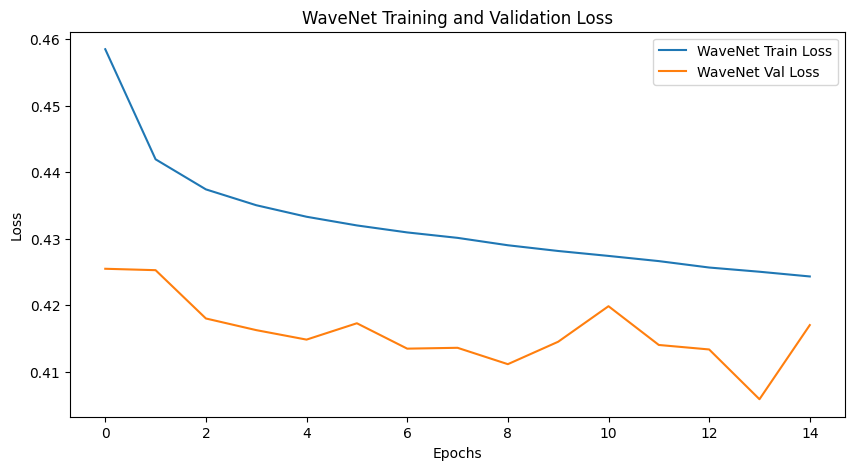

In [13]:
# Step 9: Visualize Results
import matplotlib.pyplot as plt

# Plot training loss for WaveNet
plt.figure(figsize=(10, 5))
plt.plot(history_wavenet.history['loss'], label='WaveNet Train Loss')
plt.plot(history_wavenet.history['val_loss'], label='WaveNet Val Loss')
plt.title('WaveNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

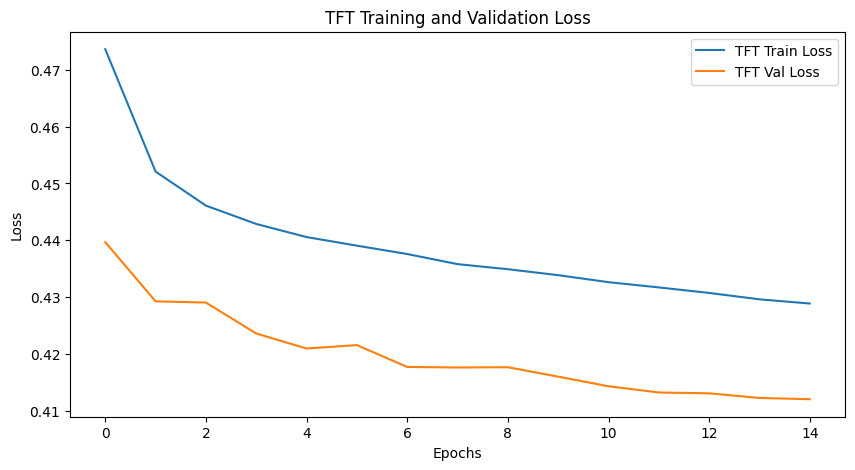

In [14]:
# Plot training loss for TFT
plt.figure(figsize=(10, 5))
plt.plot(history_tft.history['loss'], label='TFT Train Loss')
plt.plot(history_tft.history['val_loss'], label='TFT Val Loss')
plt.title('TFT Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


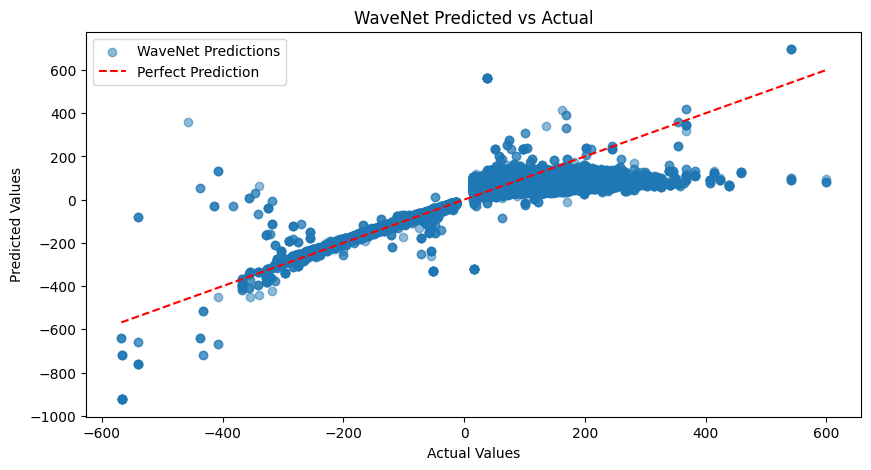

In [15]:
# Scatter plot: Predicted vs Actual for WaveNet
plt.figure(figsize=(10, 5))
plt.scatter(y_test_original.flatten(), y_pred_wavenet_original.flatten(), alpha=0.5, label='WaveNet Predictions')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', label='Perfect Prediction')
plt.title('WaveNet Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

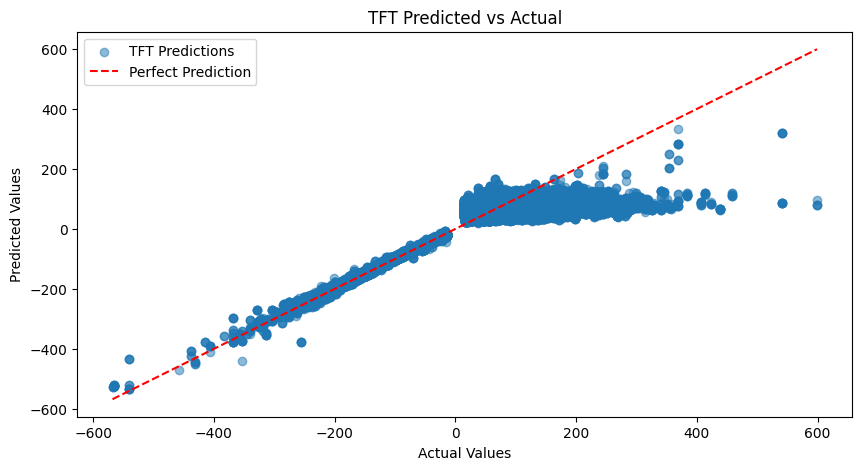

In [16]:
# Scatter plot: Predicted vs Actual for TFT
plt.figure(figsize=(10, 5))
plt.scatter(y_test_original.flatten(), y_pred_tft_original.flatten(), alpha=0.5, label='TFT Predictions')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', label='Perfect Prediction')
plt.title('TFT Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [21]:
# Save the models as "best"
enhanced_wavenet_model.save('best_wavenet_model.h5')
tft_model.save('best_tft_model.h5')

In [23]:
enhanced_wavenet_model.save('best_wavenet_model.keras')
tft_model.save('best_tft_model.keras')